# Graph Embeddings

What we are trying here for graph embedding is similar to what has been tried with the Wasserstein Weisfeiler-Lehman graph kernels. 
See https://arxiv.org/pdf/1906.01277v2.pdf.
However, instead of using Weisfeiler-Lehman kernels for averaging the appropriate vectors at each node, we iteratively use Wasserstein vectorizations on vertex neighborhoods to generate a sequece of node vectors. 

## The data: ENZYMES. 
We have 600 small graphs. There is a vector associated to each node for all graphs - this vector is given in the dataset. We want to obtain a graph vector representation. The downstream task is enzyme/graph classification: 6 classes in this dataset. The classes are balanced: 100 graphs in each class.
* https://github.com/snap-stanford/GraphRNN/tree/master/dataset/ENZYMES
* https://paperswithcode.com/sota/graph-classification-on-enzymes

## What we do in more details
We transform graphs into hypergraphs by representing each neighborhood by a hyperedge (we can include each node in its neighborhood or not). We get one hyperedge per node. These hyperedges are used to obtain new vertex vector representations (of the vertices' neighborhoods) using the Wasserstein vectorizer on all hyperedges or all graphs simultaneously. This process is then applied iteratively, using the same hyperedges but different vectors. At each iteration, we use the vertex vectors of the previous iteration. This process results in a sequence of vertex vectors that incorporate information about neighborhoods of larger radius each time: n1, n2, n3, ... 

For each vertex, we then concatenate its associated vectors to get a final vertex vector representatation. 
(n0)- vertex vector | n1-neighborhood vector | n2-neighborhood vector | ... 

Finally, we use these concatenated vertex vectors, one per vertex, to generate a graph representation via the Wasserstein vectorizer. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.feature_extraction.text
import sklearn.preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import scipy.sparse
import vectorizers
import vectorizers.transformers
import seaborn as sns
import warnings
import igraph as ig
from scipy.sparse import vstack
      
warnings.simplefilter("ignore")
sns.set()

import umap
import umap.plot
umap.plot.output_notebook()
from bokeh.plotting import show


In [2]:
import os
directory = '../data/ENZYMES/'
all_filenames =  np.sort(os.listdir(directory))
graph_filenames = [f'{directory}{x}' for x in all_filenames if x.endswith('.gml')]
label_filename = f'{directory}Labels.txt'
feature_filename = f'{directory}node_features.npy'

In [104]:
graphs = [ig.read(fname) for fname in graph_filenames]
## using 'name' -- more convenient with igraph
for g in graphs:
    g.vs['name']=g.vs['id']
    del(g.vs['id'])

# load node features for continuous graphs
node_features = np.load(feature_filename, allow_pickle=True)

with open(label_filename) as file:
    graph_labels = np.array([line.rstrip() for line in file])

In [105]:
# Making sure the graphs and the features lists are properly aligned by checking their sizes
for i in range(5):
    print(i, graphs[i].vcount(), node_features[i].shape)

0 37 (37, 18)
1 23 (23, 18)
2 25 (25, 18)
3 24 (24, 18)
4 23 (23, 18)


array([[ 1.1000000e+01,  1.5887014e+01,  3.7780000e+01, -5.1000000e-01,
         1.7010000e+00,  9.3900000e+01,  4.0000000e+00,  5.0000000e+00,
         2.0000000e+00,  4.0000000e+00,  4.0000000e+00,  3.0000000e+00,
         3.0000000e+00,  4.0000000e+00,  4.0000000e+00,  3.0000000e+00,
         6.0000000e+00,  2.0000000e+00],
       [ 1.1000000e+01,  1.6362935e+01,  4.0380000e+01, -2.0300000e+00,
         1.7770000e+00,  1.0260000e+02,  2.0000000e+00,  7.0000000e+00,
         2.0000000e+00,  6.0000000e+00,  2.0000000e+00,  3.0000000e+00,
         3.0000000e+00,  2.0000000e+00,  6.0000000e+00,  1.0000000e+00,
         8.0000000e+00,  2.0000000e+00],
       [ 1.6000000e+01,  2.1395072e+01,  6.3350000e+01,  2.0400000e+00,
         2.9810000e+00,  1.3600000e+02,  2.0000000e+00,  7.0000000e+00,
         7.0000000e+00,  6.0000000e+00,  4.0000000e+00,  6.0000000e+00,
         6.0000000e+00,  2.0000000e+00,  8.0000000e+00,  2.0000000e+00,
         7.0000000e+00,  7.0000000e+00],
       [ 6.00

In [106]:
vertex_vectors_0 = np.vstack(node_features)

In [107]:
vertex_vectors_0.shape

(19474, 18)

In [108]:
graphs_vertices = [[str(x) for x in list(np.sort([int(v['name']) for v in g.vs]))] for g in graphs]

In [109]:
vertex_names = list(np.hstack(graphs_vertices))
vertex_names_dictionary = dict()
for i, v in enumerate(vertex_names):
    vertex_names_dictionary[v] = i
    
n_vertices = len(vertex_names_dictionary)

In [154]:
%%time
incidence_vectorizer = vectorizers.NgramVectorizer(
    token_dictionary=vertex_names_dictionary
).fit(graphs_vertices)

incidence_matrix = incidence_vectorizer.transform(graphs_vertices)

CPU times: user 154 ms, sys: 3.78 ms, total: 158 ms
Wall time: 155 ms


In [182]:
incidence_matrix.shape

(600, 19474)

# Data description

We have 600 enzymes/graphs. Graphs may contain up to 125 nodes, or as little as 2 nodes, but the average is around 32. You can see the graph size distribution below.

With all graphs together, there is a total of 19,474 vertices overall. 

In [155]:
print(np.max(incidence_matrix.sum(axis=1)))
print(np.min(incidence_matrix.sum(axis=1)))
print(np.mean(incidence_matrix.sum(axis=1)))

125.0
2.0
32.456665


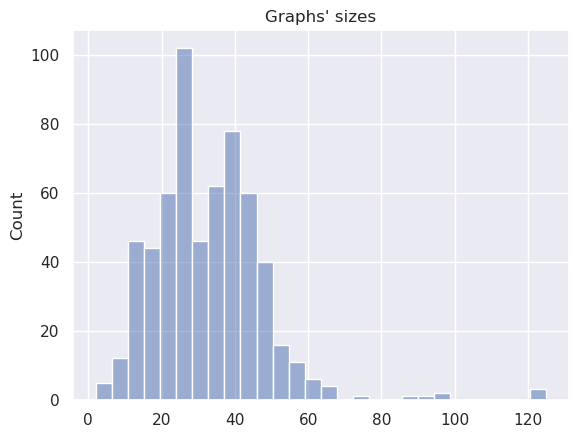

In [156]:
sns.histplot(incidence_matrix.sum(axis=1), legend=False).set_title("Graphs' sizes");

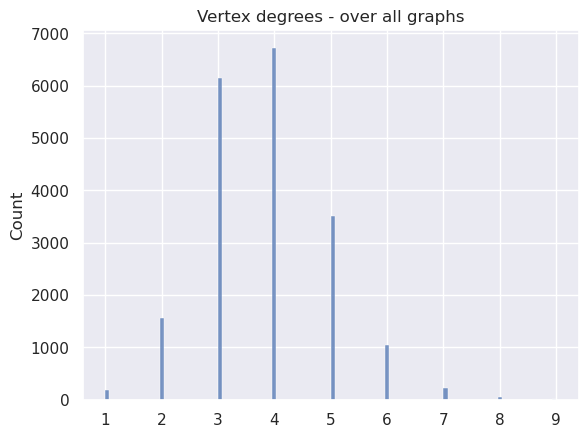

In [157]:
vertex_degrees = [deg for g in graphs for deg in g.degree()]
len(vertex_degrees)
sns.histplot(vertex_degrees, legend=False).set_title("Vertex degrees - over all graphs");

##### Embed graphs as bags of vertex vectors (Wasserstein)

In [158]:
%%time
# n_components = vertex_vectors_0.shape[0]
graph_awe_matrix_0 = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    # n_components=n_components,
    random_state=42,
).fit_transform(incidence_matrix, vectors=vertex_vectors_0)

graph_awe_matrix_0.shape

CPU times: user 256 ms, sys: 8.57 ms, total: 264 ms
Wall time: 10.2 ms


(600, 18)

In [159]:
g_mapper = umap.UMAP(random_state=42).fit(graph_awe_matrix_0)
p = umap.plot.interactive(
    M_mapper_norm_1, 
    labels=graph_labels,
    point_size=3, 
    width=800, 
    height=600, 
    theme='fire')
show(p)

##### Embed neighborhoods as bags of vertex vectors (Wasserstein)

To do this, we consider each neighborhood as a hyperedge assigned to a vertex, and we build a node incidence matrix of this hypergraph.

In [160]:
G = ig.union([g for g in graphs])
node_incidence_matrix = G.get_adjacency_sparse()
node_incidence_matrix.setdiag(1) ## add self to neighbourhoods
node_incidence_matrix

<19474x19474 sparse matrix of type '<class 'numpy.int64'>'
	with 94038 stored elements in Compressed Sparse Row format>

In [161]:
hyperedges_all = [ [str(int(G.vs[x]['name'])) for x in G.neighborhood(v)] for v in range(G.vcount())]


##### Effect of vector normalization?

In [162]:
vertex_vectors_norm_0 = normalize(vertex_vectors_0, axis=1, norm='l1')

graph_awe_matrix_norm_0 = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    
    # n_components=n_components,
    random_state=42,
).fit_transform(incidence_matrix, vectors=vertex_vectors_norm_0)

##### Iteratively embed vertices as bags (n1-neighborhoods) of vertices (via Wasserstein)

In [163]:
vertex_awe_vectors = dict()
graph_awe_matrix = dict()
graph_awe_matrix_svd = dict()

In [164]:
number_iteration = 3

In [165]:
vertex_awe_vectors[0] = vertex_vectors_0
graph_awe_matrix[0] = graph_awe_matrix_0

In [166]:
vertex_awe_vectors[0] = normalize(vertex_awe_vectors[0], axis=1, norm='l1')
n_components = vertex_awe_vectors[0].shape[1]
svd = TruncatedSVD(n_components=n_components)

for i in range(1,number_iteration):
    vertex_awe_vectors[i] = vectorizers.ApproximateWassersteinVectorizer(
        normalization_power=0.66,
        random_state=42,
        # n_components=n_components
    ).fit_transform(node_incidence_matrix, vectors=vertex_awe_vectors[i-1])


    vertex_awe_vectors[i] = normalize(vertex_awe_vectors[i], axis=1, norm='l1')

    graph_awe_matrix[i] = vectorizers.ApproximateWassersteinVectorizer(
        random_state=42,
        # n_components=n_components,
        normalization_power=0.66,
    ).fit_transform(incidence_matrix, 
                    vectors=np.hstack([vertex_awe_vectors[i] for j in range(i+1)])
                   )
    
    graph_awe_matrix_svd[i] = svd.fit_transform(graph_awe_matrix[i])
    
    print(f'Interation {i}, shape of vector matrix {vertex_awe_vectors[i].shape}, shape of graph matrix {graph_awe_matrix[i].shape}')

Interation 1, shape of vector matrix (19474, 18), shape of graph matrix (600, 36)
Interation 2, shape of vector matrix (19474, 18), shape of graph matrix (600, 54)


In [167]:
vector_df = pd.DataFrame()
vector_df['groups'] = np.hstack(np.array([i]*vertex_awe_vectors[i].shape[0]) for i in range(number_iteration))
vector_df['lengths'] = np.hstack(np.linalg.norm(vertex_awe_vectors[i], axis=1, ord=1) for i in range(number_iteration))

# Downstream Task Comparison

Let's see how that does on the classification task

Currently, there is no use of using TF-IDF or info-gain as each node appears only once. If we were to use the vector representation of nodes, we could use a continuous version of info gain... not sure how to do this.

In [168]:
import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors

from sklearn.experimental import enable_hist_gradient_boosting

In [169]:
def cross_validate(model, data, labels, n_splits=20, test_ratio=0.1, random_seed=42):
    splitter = sklearn.model_selection.ShuffleSplit(
        n_splits=n_splits, test_size=test_ratio, random_state=random_seed
    )
    result = sklearn.model_selection.cross_val_score(model, data, labels, cv=splitter)
    return result

def cross_validation_dataframe(model, data, labels, feature_sets, n_splits=20, test_ratio=0.1, random_seed=42):
    dfs = []
    for feature_space_name, feature_space in feature_sets.items():
        cv_scores = cross_validate(model, feature_space, labels, n_splits, test_ratio, random_seed)
        feature_df = pd.DataFrame(
            {
                "run" : np.arange(n_splits), 
                "Embedding" : feature_space_name,
                "Model" : model.__repr__().split("(")[0],
                "Accuracy" : cv_scores,
            }
        )
        dfs.append(feature_df)
    return pd.concat(dfs)

## Normalization effect on downstream task - no neighborhoods

Here, we just represent graphs as bag of vertex vectors: no Weisfeiler-Lehman graph kernels, no Wasserstein vectorizing of neighborhoods. This method works remarkably well for our graphs given its simplicity. We get a average of roughly 70% with a RandomForest classifier, comparable to the baseline in the paper (RBF-WL radial basis function with Weisfeiler-Lehman).

It seems like the neighborhoods do not bring 

The results found in https://arxiv.org/pdf/1906.01277v2.pdf

![image.png](attachment:588ffce4-bedd-4761-8d3a-2c004e3b5d26.png)

The leaderboard found at https://paperswithcode.com/sota/graph-classification-on-enzymes

In [170]:
from collections import Counter
Counter(graph_labels)

Counter({'6': 100, '5': 100, '1': 100, '2': 100, '3': 100, '4': 100})

In [171]:
models_norm = [
    sklearn.neighbors.KNeighborsClassifier(metric="cosine", n_neighbors=10, weights="distance"),
    # sklearn.ensemble.HistGradientBoostingClassifier(),
    sklearn.ensemble.RandomForestClassifier(),
    # sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, 80, 40))
]
feature_sets_norm = {
    "Wasserstein original": graph_awe_matrix_0,
    "Wasserstein normalized":  graph_awe_matrix_norm_0
}

In [172]:
%%time
results_norm = []
for model in models_norm:
    print(model)
    res = cross_validation_dataframe(
        model, 
        feature_sets_norm,
        graph_labels,
        feature_sets = feature_sets_norm
    )
    results_norm.append(res)

df_norm = pd.concat( results_norm )

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')
RandomForestClassifier()
CPU times: user 19.4 s, sys: 511 ms, total: 19.9 s
Wall time: 9.73 s


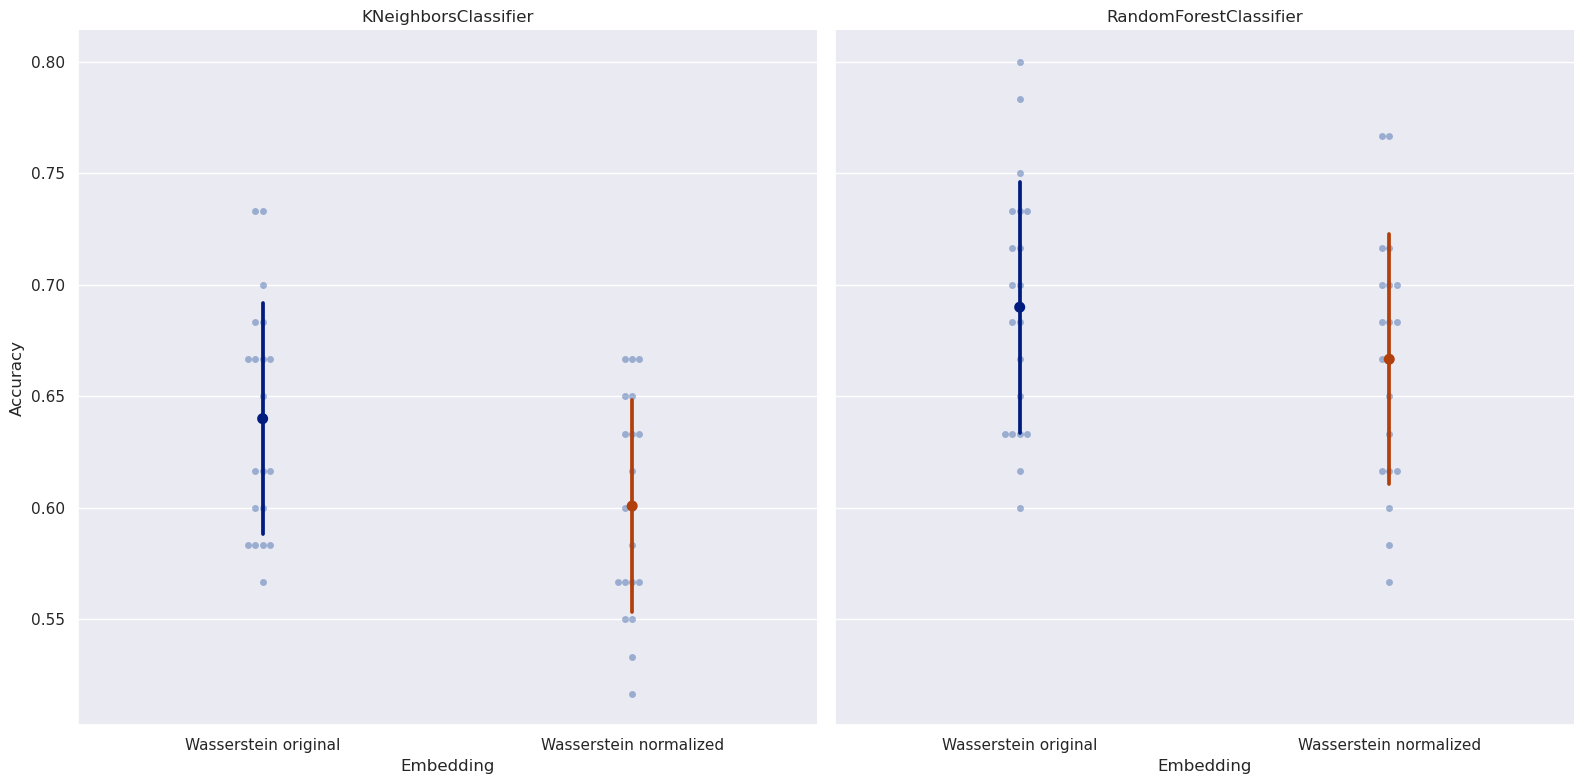

In [173]:
g = sns.catplot(
    kind="swarm", 
    x="Embedding", 
    y="Accuracy", 
    col="Model",
    col_wrap=2,
    data=df_norm, 
    height=8, 
    alpha=0.5,
    zorder=1,
)
g.map_dataframe(
    sns.pointplot, 
    x="Embedding", 
    y="Accuracy", 
    color="Model", 
    data=df_norm, 
    # height=6, 
    # aspect=1.3,
    palette="dark",
    join=False,
    order=[
        "Wasserstein original",
        "Wasserstein normalized"
    ],
    ci="sd",
    # zorder=2,
    scale=0.9,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels([
        "Wasserstein original",
        "Wasserstein normalized"
    ])

It seems like normalizing the vectors is not helpful but does not degrade the results all that much. The problem is that if we are to concatenate vectors that incorporate information of different neighborhoods' sizes, the vectors obtained via the Wasserstein vectorizer and the initial vectors are not on comparable scales. This is why, in the next section, we normalize all vectors.

## Concatenating neighborhood vectors on downstream task

In [174]:
models = [
    sklearn.neighbors.KNeighborsClassifier(metric="cosine", n_neighbors=10, weights="distance"),
    # sklearn.ensemble.HistGradientBoostingClassifier(),
    sklearn.ensemble.RandomForestClassifier(),
    # sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, 80, 40))
]
feature_sets = {
    f"AW {i}-times ": graph_awe_matrix[i] for i in range(number_iteration)
}
feature_sets.update({
    f"AW-svd {i}-times ": graph_awe_matrix_svd[i] for i in range(1, number_iteration)
})

order = [
        f"AW {i}-times " for i in range(number_iteration)
    ] + [
        f"AW-svd {i}-times " for i in range(1, number_iteration)
    ]

Now we reun the cross validation across all the models and all the feature sets. Be forewarned if you run this, it will take quite a while.

In [175]:
%%time
results = []
for model in models:
    print(model)
    res = cross_validation_dataframe(
        model, 
        feature_sets,
        graph_labels,
        feature_sets
    )
    results.append(res)

df_all = pd.concat( results )

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')
RandomForestClassifier()
CPU times: user 41.6 s, sys: 935 ms, total: 42.5 s
Wall time: 25.7 s


In [176]:
df = df_all

In [178]:
df_all

,run,Embedding,Model,Accuracy
0,0,AW 0-times,KNeighborsClassifier,0.683333
1,1,AW 0-times,KNeighborsClassifier,0.666667
2,2,AW 0-times,KNeighborsClassifier,0.566667
3,3,AW 0-times,KNeighborsClassifier,0.650000
4,4,AW 0-times,KNeighborsClassifier,0.600000
...,...,...,...,...
15,15,AW-svd 2-times,RandomForestClassifier,0.616667
16,16,AW-svd 2-times,RandomForestClassifier,0.550000
17,17,AW-svd 2-times,RandomForestClassifier,0.533333
18,18,AW-svd 2-times,RandomForestClassifier,0.550000


Finally we plot the results. We'll make some good use of seaborn to get a good looking comparison out.

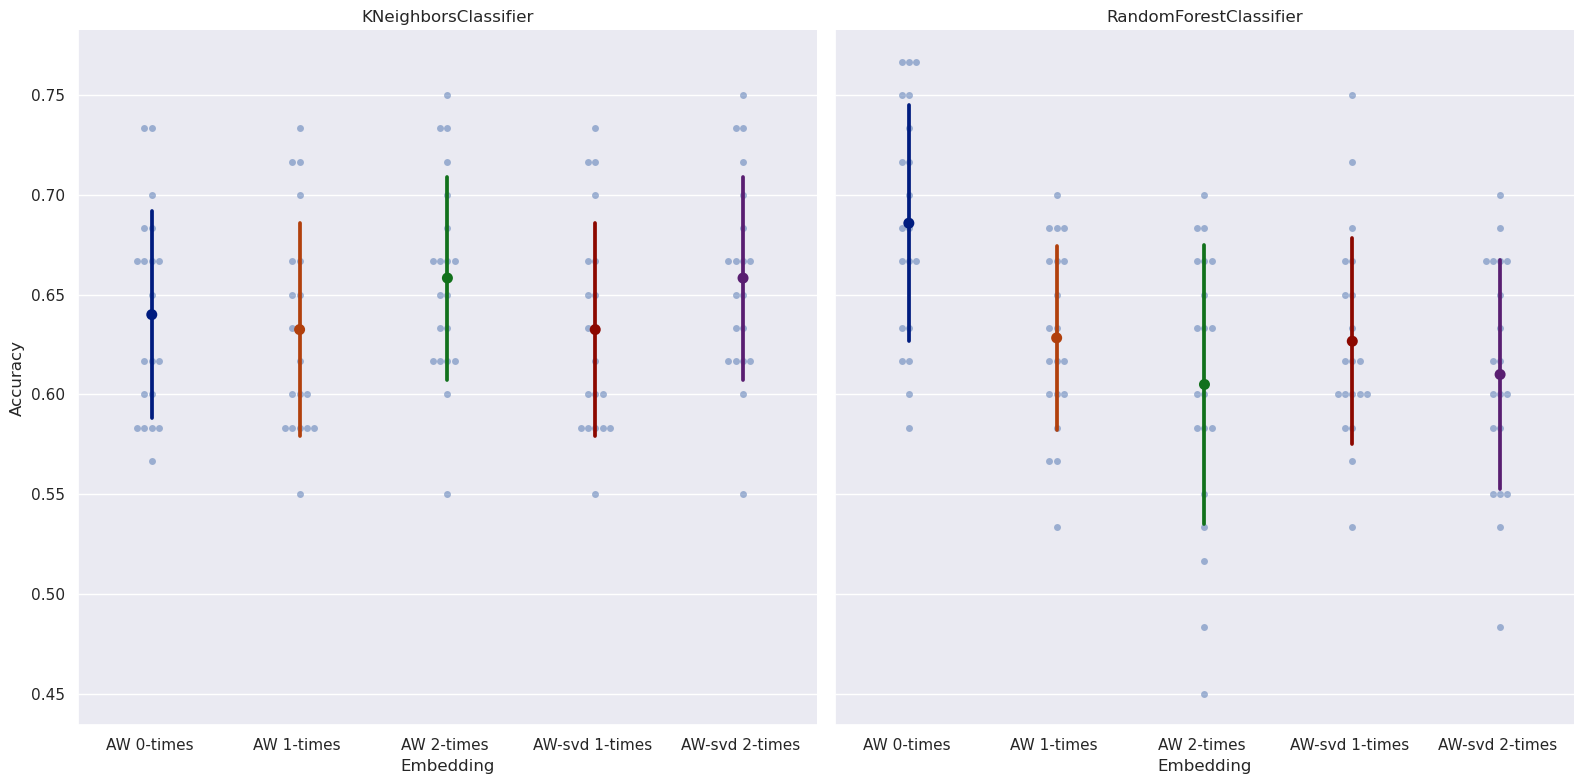

In [177]:
g = sns.catplot(
    kind="swarm", 
    x="Embedding", 
    y="Accuracy", 
    col="Model",
    col_wrap=2,
    data=df, 
    height=8, 
    alpha=0.5,
    zorder=1,
)
g.map_dataframe(
    sns.pointplot, 
    x="Embedding", 
    y="Accuracy", 
    color="Model", 
    data=df, 
    # height=6, 
    # aspect=1.3,
    palette="dark",
    join=False,
    order= order
    ,
    ci="sd",
    # zorder=2,
    scale=0.9,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(order)
# g.savefig("figures/recipe_embedding_comparison_downstream_task.png", facecolor="none")